In [1]:
import arviz as az
import numpy as np  # For vectorized math operations

import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r
import seaborn as sns
from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format='retina'

sns.set_theme(
    context="notebook",
    style="white",
    font="Latin Modern Roman",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "text.usetex": True,
    },
)

extra_params = {
    "text.latex.preamble": " ".join([r"\usepackage{mathtools}", r"\usepackage{amssymb}"])
}

plt.rcParams.update(extra_params)

# Introduction

Data generating process is:
$$
u_{ij} = {x_i}'\beta^{\text{individual}}_{i} + {c_j}'\beta^{\text{product}}_{i} + \eta_{ij} - \eta_{i0}
$$
where
- the consumer knows $\left(x_i, \beta^{\text{individual}}_i, c_j, \beta^{\text{product}}_{i}, \eta_{ij}\right)$, which implies outcome variables $\left(t_i, w_i\right)$
- the econometrician knows $\left(x_i, c_j, t_i, w_i\right)$ and has priors over $\left(\beta^{\text{individual}}, \beta^{\text{product}}\right)$
- neither the consumer nor the econometrician knows $\eta_{i0}$, but they have common priors

Consumer reports
- their preferred good $j^{(1)}$
- the probability they purchase the good on a Likert scale with $W$ categories

## Notation

- $N$ is the number of individuals
- $J$ is the number of products
- $K$ is the number of product attributes
- $M$ is the number of individual attributes
- $W$ is the number of categories on the Likert scale

## Classic Multinomial Logit

### Simulate Data

In [52]:
def make_data(params, heterogeneous=False):

    ## load parameters
    M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    ## generate latent parameters
    # individual_features = np.random.normal(0, 0.1, (N, M))
    # individual_features = np.zeros((N, M))
    individual_features = ...
    
    # product_features = np.random.normal(0, 0.5, (J, K))
    # product_features = np.concatenate(
    #     [product_features, np.zeros((1, K))], axis=0
    # )  # outside good
    
    product_features = np.random.normal(0, 0.2, (N, J, K))
    product_features = np.concatenate(
        [product_features, np.zeros((N, 1, K))], axis=1
    )  # outside good

    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    β_ind = ...
    # β_ind = np.random.normal(0, 1, M)
    # β_prod = np.random.normal(0, 0.2, (K, N))
    # ν = np.random.normal(0, 1, (N, J))
    η = np.random.gumbel(0, 1, (N, J + 1))
    # ɛ = np.random.normal(0, 1, (N, J))

    if heterogeneous:
        α_prod = ...
        β_prod = np.random.normal(0, 1, (K, N))
    
    else:
        
        α_prod = np.random.normal(-1.0, 0.2, J+1)
        α_prod[-1] = 0 # outside good

        # β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
        β_prod = np.random.normal(0, 1, K)
    
    ## generate data
    # y = np.zeros((N, J))

    # u_individual = np.outer(
    #     individual_features @ β_ind,
    #     np.ones(J),
    # )
    # u = β_prod @ product_features.T + η

    u = np.ones((N, 1)) @ α_prod.reshape((1, -1)) + product_features @ β_prod + η
    
    if heterogeneous:
        u_individual = ...
        u += u_individual

    t = np.argmax(u, axis=1)
    jstar = np.argmax(u[:, :-1], axis=1)
    v = u[:, t]
    w = np.digitize(gumbel_r.cdf(v), π)

    d = {
        "product_features": product_features,
        "t": t,
        "w": w,
        "jstar": jstar,
        "latent_cutpoints": π,
        "latent_utilities": u,
        "latent_α_prod": α_prod,
        "latent_β_prod": β_prod,
    }

    if heterogeneous:
        d["individual_features"] = individual_features
        d["latent_β_ind"] = β_ind

    return d


params = {"N": 200, "J": 3, "K": 5, "M": 2, "W": 4}

df = make_data(params)

### Visualize the Data

In [44]:
# df["t"]
# df["product_features"]

In [54]:
df["latent_α_prod"]

array([-1.06782446, -0.92598778, -1.02474654,  0.        ])

In [53]:
df["latent_β_prod"]

array([-0.49693203, -0.18256897, -0.98995779, -0.03500761, -0.81100086])

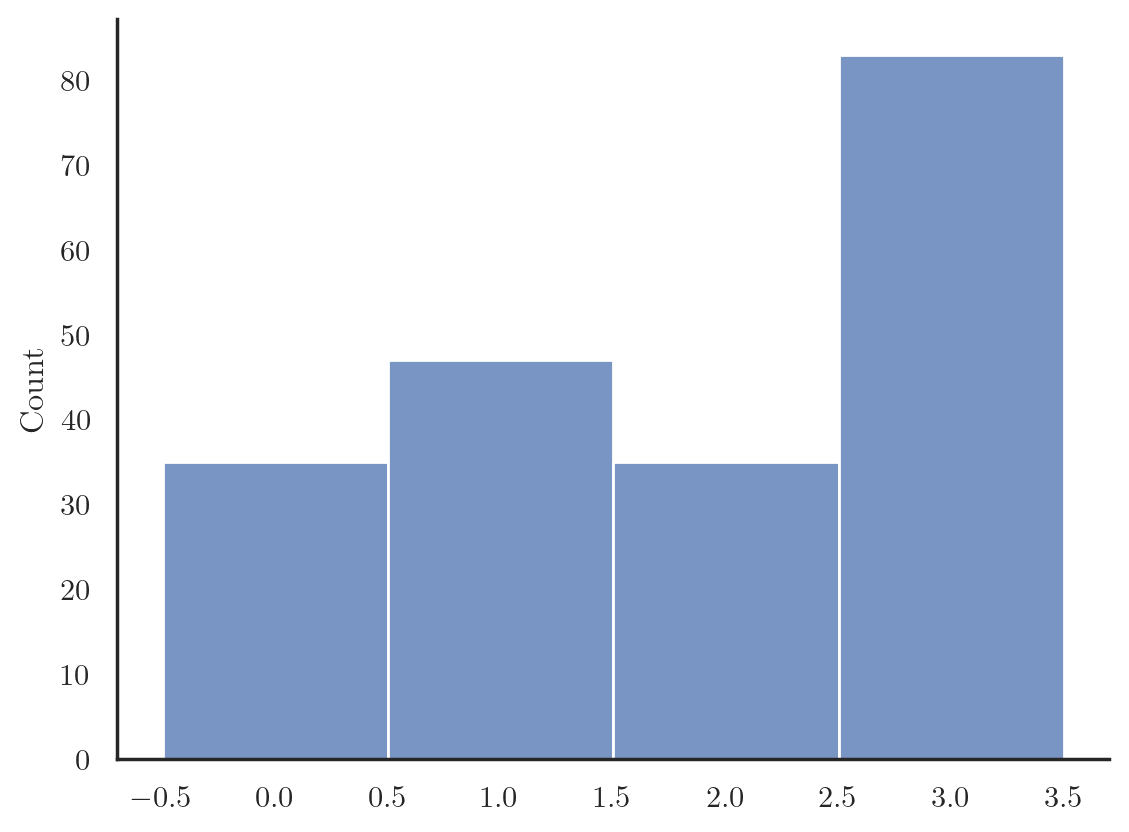

In [55]:
sns.histplot(df["t"], discrete=True)
plt.show()

### Export Data

In [57]:
out_data2 = np.array(
    [
        [n, j, df["jstar"][n] == j, *df["product_features"][n, j, :], df["jstar"][n] == df["t"][n]]
        for n in range(params["N"])
        for j in range(params["J"])
    ]
)

In [58]:
out_data2[out_data2[:, -1] == 0, :-1].shape

(249, 8)

In [59]:
out_data1 = np.array(
    [
        [n, j, 0, df["t"][n] == j, *df["product_features"][n, j, :]]
        for n in range(params["N"])
        for j in range(params["J"] + 1)
    ]
)

out_data2 = np.array(
    [
        [
            n,
            j,
            1, 
            df["jstar"][n] == j,
            *df["product_features"][n, j, :],
            df["jstar"][n] == df["t"][n],
        ]
        for n in range(params["N"])
        for j in range(params["J"])
    ]
)
out_data = np.concatenate([out_data1, out_data2[out_data2[:, -1] == 0, :-1]], axis=0)
pd.DataFrame(
    out_data,
    columns=[
        "consumer_id",
        "choice_id",
        "task_id",
        "purchase",
        *[f"f_{k}" for k in range(params["K"])],
    ],
).to_csv("/Users/gzheng/Desktop/data.csv", index=False)

First, try "classical" conjoint, in which $\eta_0$ is observed by the consumer.

In [60]:
# def gumbel_pdf(x, mu=0, beta=1):
#     z = (x - mu) / beta
#     return np.exp(-(z + np.exp(-z)))


# def gumbel_cdf(x, mu=0, beta=1):
#     z = (x - mu) / beta
#     return np.exp(-np.exp(-z))

# μbar = np.log(np.sum(np.exp(df["latent_β_prod"][:] @ df["product_features"].T)))
# sns.histplot(np.max(df["latent_utilities"], axis=1), stat="density")
# plot_args = dict(
#     zip(
#         ["x", "y"],
#         zip(
#             *(
#                 (x, gumbel_r.pdf(x, μbar))
#                 for x in np.linspace(
#                     *np.percentile(np.max(df["latent_utilities"], axis=1), [0.1, 99.9]),
#                     100,
#                 )
#             )
#         ),
#     )
# )
# sns.lineplot(
#     **plot_args,
#     linestyle="dashed",
# )
# plt.show()

### Estimate the Model

In [61]:
observed_good = df["t"]

N = params["N"]
M = params["M"]
J = params["J"]
K = params["K"]
W = params["W"]
# J, K = df["product_features"].shape
# W = len(np.unique(observed_bin))


coords_1 = {
    "products": [f"product_{i}" for i in range(J + 1)],
    "i_factors": [f"if_{i}" for i in range(M)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

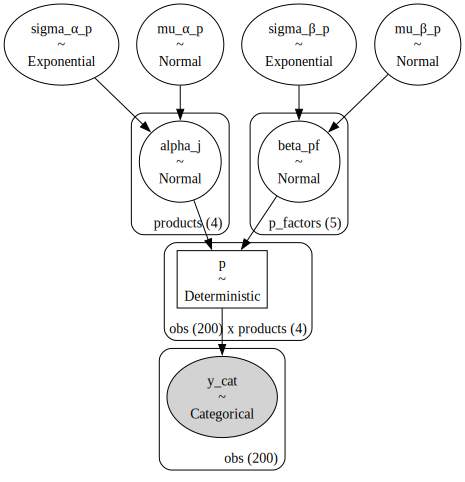

In [62]:
with pm.Model(coords=coords_1) as model_1:

    mu_α_p = pm.Normal("mu_α_p", 0, 1)
    sigma_α_p = pm.Exponential("sigma_α_p", 1)

    alpha_p = pm.Normal("alpha_j", mu_α_p, sigma_α_p, dims=["products"])
    alpha_p = pt.set_subtensor(alpha_p[-1], 0) #outside good

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    # beta_p = (
    #     pm.math.ones((N, 1))
    #     * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    # )  # want there to be N*K beta's

    beta_p = pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"])

    ## Construct Utility matrix

    # beta_p_print = Print("beta_p")(beta_p)

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + df["product_features"] @ beta_p

    # s_print = Print("s")(s)
    # s = beta_p @ df["product_features"].T
    # s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

pm.model_to_graphviz(model_1)

In [63]:
with model_1:
    # idata_m1 = pm.sample_prior_predictive()
    # idata_m1.extend(
    #     pm.sample(
    #         5000,
    #         nuts_sampler="numpyro",
    #         idata_kwargs={"log_likelihood": True},
    #         random_seed=100,
    #     )
    # )
    # idata_m1.extend(pm.sample_posterior_predictive(idata_m1))
    idata_m1 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

There were 2581 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [64]:
az.summary(idata_m1, var_names=["beta_pf"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],-0.767,0.341,-1.418,-0.113,0.009,0.006,1304.0,649.0,1.00
beta_pf[pf_1],-0.565,0.323,-1.130,0.105,0.009,0.007,1363.0,2377.0,1.01
beta_pf[pf_2],-0.630,0.326,-1.245,0.010,0.008,0.005,1756.0,2448.0,1.01
beta_pf[pf_3],-0.734,0.341,-1.377,-0.078,0.011,0.008,946.0,581.0,1.00
beta_pf[pf_4],-0.626,0.332,-1.277,0.007,0.011,0.009,939.0,866.0,1.01


In [65]:
post = az.extract(idata_m1)

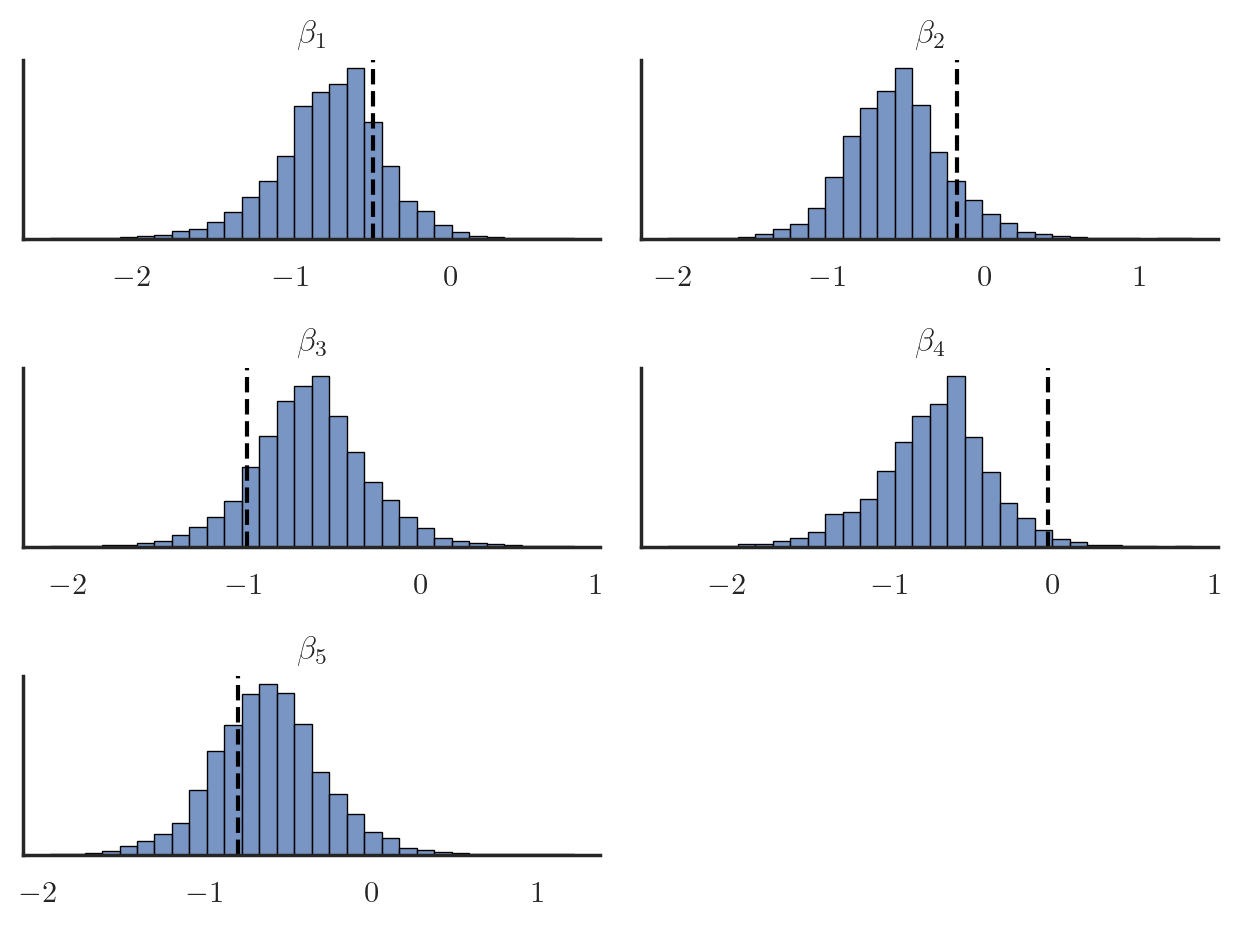

In [66]:
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_prod"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

## Likert Dual Response

### Construct the Model

In [67]:
observed_inside = df["jstar"]
observed_buy = df["t"] == df["jstar"]

N = params["N"]
J = params["J"]
K = params["K"]

coords_2 = {
    "products": [f"product_{i}" for i in range(J)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

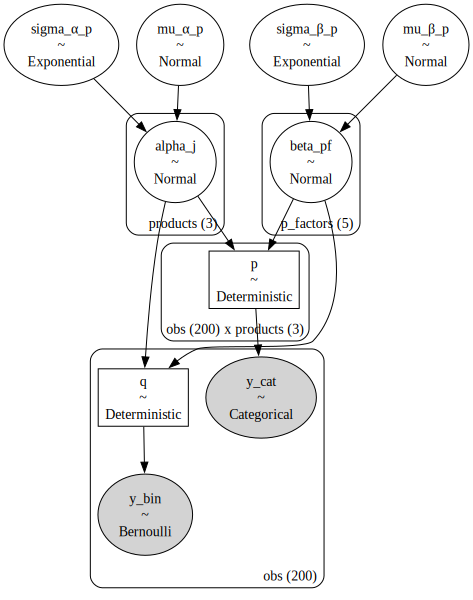

In [68]:
with pm.Model(coords=coords_2) as model_2:

    mu_α_p = pm.Normal("mu_α_p", 0, 1)
    sigma_α_p = pm.Exponential("sigma_α_p", 1)

    alpha_p = pm.Normal("alpha_j", mu_α_p, sigma_α_p, dims=["products"])
    
    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    
    beta_p = pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"])

    ## Construct Utility matrix

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + df["product_features"][:, :-1, :] @ beta_p

    ## Construct Probabilities
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))
    q_ = pm.Deterministic("q", pm.math.log(pm.math.sum(pm.math.exp(s), axis=1)), dims="obs")
    
    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_inside, dims="obs")
    bin_obs = pm.Bernoulli("y_bin", logit_p = q_, observed=observed_buy, dims="obs")

pm.model_to_graphviz(model_2)

### Estimate the Model

In [69]:
with model_2:
    idata_m2 = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

There were 2142 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Visualize the Estimates

In [70]:
az.summary(idata_m2, var_names=["beta_pf"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],-0.959,0.295,-1.555,-0.429,0.005,0.004,3339.0,6046.0,1.00
beta_pf[pf_1],-0.640,0.314,-1.181,-0.024,0.007,0.005,1695.0,2755.0,1.00
beta_pf[pf_2],-0.855,0.294,-1.433,-0.296,0.005,0.004,2917.0,2282.0,1.00
beta_pf[pf_3],-0.730,0.300,-1.247,-0.114,0.006,0.004,2473.0,3577.0,1.00
beta_pf[pf_4],-0.947,0.295,-1.520,-0.400,0.006,0.005,2395.0,2459.0,1.01


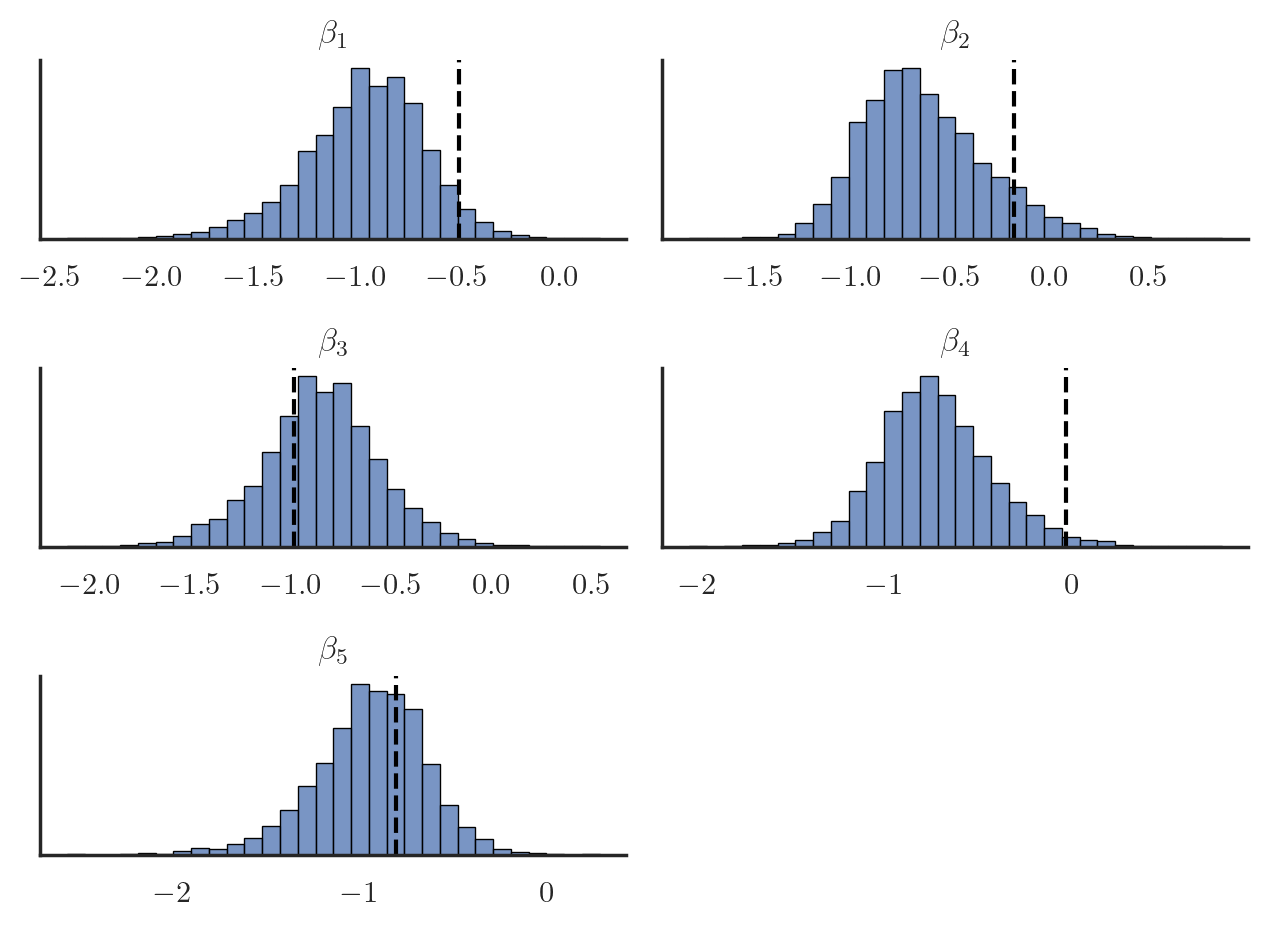

In [71]:
post = az.extract(idata_m2)
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_prod"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

### Construct the "Synthetic Data" Model

In [72]:
observed_inside = df["jstar"]
observed_good = df["t"]

N = params["N"]
J = params["J"]
K = params["K"]

coords_2p = {
    "products": [f"product_{i}" for i in range(J+1)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

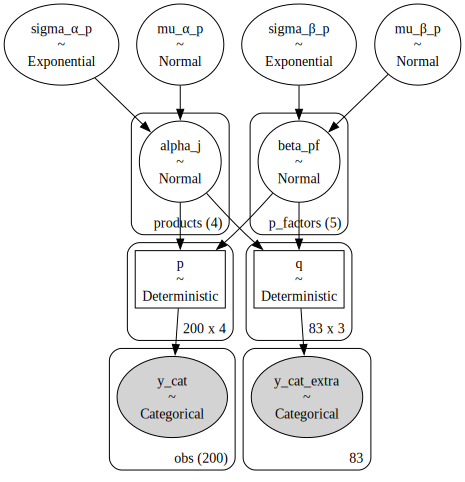

In [73]:
with pm.Model(coords=coords_2p) as model_2p:

    mu_α_p = pm.Normal("mu_α_p", 0, 1)
    sigma_α_p = pm.Exponential("sigma_α_p", 1)

    alpha_p = pm.Normal("alpha_j", mu_α_p, sigma_α_p, dims=["products"])
    alpha_p = pt.set_subtensor(alpha_p[-1], 0) #outside good

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    
    beta_p = pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"])

    ## Construct Utility matrix

    s = pm.math.ones((N, 1)) @ alpha_p.reshape((1, -1)) + df["product_features"] @ beta_p

    ## Construct Probabilities
    extra_info_indices = observed_good == J
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1)) #all goods
    q_ = pm.Deterministic("q", pm.math.softmax(s[extra_info_indices, :-1], axis=1)) #inside goods
    
    
    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")
    choice_obs_extra = pm.Categorical("y_cat_extra", p=q_, observed=observed_inside[extra_info_indices])
    

pm.model_to_graphviz(model_2p)

### Estimate the Model

In [74]:
with model_2p:
    idata_m2p = pm.sample(
        5000,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

There were 1427 divergences after tuning. Increase `target_accept` or reparameterize.


### Visualize the Estimates

In [75]:
# standard errors are too small
az.summary(idata_m2p, var_names=["beta_pf"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],-0.957,0.308,-1.549,-0.397,0.006,0.005,2318.0,2683.0,1.0
beta_pf[pf_1],-0.647,0.303,-1.166,-0.025,0.006,0.004,2965.0,3448.0,1.0
beta_pf[pf_2],-0.841,0.291,-1.427,-0.326,0.005,0.003,3999.0,4192.0,1.0
beta_pf[pf_3],-0.724,0.302,-1.299,-0.159,0.005,0.003,3710.0,3996.0,1.0
beta_pf[pf_4],-0.932,0.301,-1.534,-0.411,0.006,0.004,2483.0,2930.0,1.0


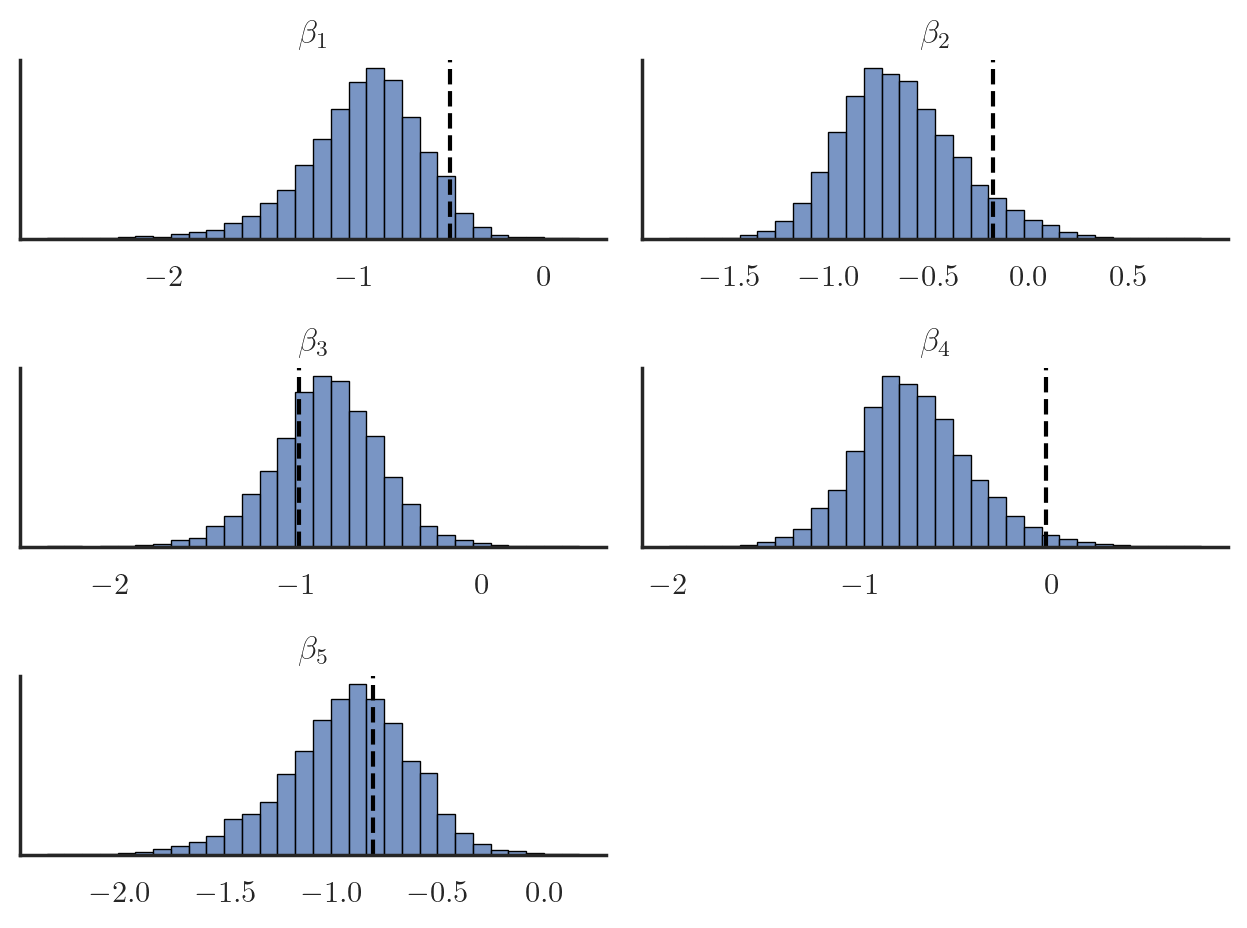

In [76]:
post = az.extract(idata_m2p)
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_prod"][i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

## Likert Multinomial Logit (ALL BELOW IS OLD)

### Simulate Data

In [14]:
def make_data(params):

    ## load parameters
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    ## generate latent parameters
    product_features = np.random.normal(-1, 0.2, (J, K))
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    η = np.random.gumbel(0, 1, (N, J))
    # ɛ = np.random.normal(0, 1, (N, J))

    β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
    ## generate data
    # y = np.zeros((N, J))

    u = β_prod @ product_features.T + η

    t = np.argmax(u, axis=1)
    v = u[np.arange(N), t]
    w = np.digitize(gumbel_r.cdf(v), π)

    d = {
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_cutpoints": π,
        "latent_utilities": u,
        "latent_β_prod": β_prod,
    }
    
    return d


params = {"N": 1000, "J": 3, "K": 5, "M": 2, "W": 4}

df = make_data(params)

In [15]:
observed_good = df["t"]
observed_bin = df["w"]

N = params["N"]
J = params["J"]
K = params["K"]
W = params["W"]


coords = {
    "products": [f"product_{i}" for i in range(J)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
    "bins": range(W)
}

In [ ]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    ## Construct Utility matrix

    s = beta_p @ df["product_features"].T
    u = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))
    # s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
    π = pm.Deterministic(
        "latent_cutpoints", pm.math.cumsum(π)
    )
    cutpoints = -pm.math.log(-pm.math.log(π[:-1]))

    ## Likelihood
    choice_obs = pm.Categorical("preferred_good", p=p_, observed=observed_good, dims="obs")
    bin_obs = pm.OrderedLogistic("buy_probability", eta=u, cutpoints=cutpoints, observed=observed_bin)

pm.model_to_graphviz(model_1)

In [ ]:
with model_1:
    idata_m1 = (
        pm.sample(
            5000,
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )

In [ ]:
az.summary(idata_m1, var_names=["beta_pf"])

In [ ]:
post = az.extract(idata_m1)
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_prod"][0, i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

### Individual-specific $\beta$ (To Do...)

In [20]:
def make_data(params):

    ## load parameters
    M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    ## generate latent parameters

    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    η = np.random.gumbel(0, 1, (N, J))
    β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))

    ## generate observable product features

    product_features = np.random.normal(-1, 0.2, (J, K))

    ## generate data
    u = β_prod @ product_features.T + η

    t = np.argmax(u, axis=1)
    v = u[np.arange(N), t]
    w = np.digitize(gumbel_r.cdf(v), π)

    d = {
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_cutpoints": π,
        "latent_utilities": u,
        "latent_β_prod": β_prod,
    }

    return d


params = {"N": 1000, "J": 3, "K": 5, "M": 2, "W": 4}

df = make_data(params)

In [ ]:
sns.barplot(**dict(zip(["x", "y"], np.unique(df["w"], return_counts=True))))
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i >= J:
        plt.gca().axis("off")
        continue
    # sns.barplot(**dict(zip(["x", "y"], np.unique(df["w"][df["t"] == i], return_counts=True))))
    sns.histplot(df["w"][df["t"] == i], stat="density", discrete=True)
    plt.title(rf"$K={i}$")
    
plt.suptitle(r"$\mathbb{P}\left(\text{Buy}\,\middle\vert\,K\right)$")
# plt.suptitle("abc")
plt.tight_layout()
plt.show()

In [23]:
observed_good = df["t"]
observed_bin = df["w"]

N = params["N"]
M = params["M"]
J = params["J"]
K = params["K"]
W = params["W"]
# J, K = df["product_features"].shape
# W = len(np.unique(observed_bin))


coords = {
    "products": [f"product_{i}" for i in range(J)],
    "i_factors": [f"if_{i}" for i in range(N)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

In [ ]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 5)

    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
    α = pm.Deterministic(
        "latent_cutpoints", pm.math.concatenate([np.ones(1) * 0, pm.math.cumsum(π)])
    )  # (W+1) x 1

    ## Construct Utility matrix

    s_good = beta_p @ df["product_features"].T

    # s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)
    
    s = s_good

    ## Calculate good conditional likelihoods
    
    p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J
    
    ## Apply Softmax Transform
    
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))
   
    ## Apply Gumbel-Max Adjustment
    
    μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1    

    ## Likelihood
    
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")
    bin_obs = pm.OrderedLogistic("bin", eta=μbar, cutpoints=α, observed=observed_bin, dims="obs")
 
pm.model_to_graphviz(model_1)

In [ ]:
with model_1:
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            5000,
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

In [ ]:
post = az.extract(idata_m1)
fig, axs = plt.subplots(3, 2)

for i in range(6):
    plt.sca(axs.flatten()[i])
    if i >= K:
        plt.gca().axis("off")
        continue
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_prod"][0, i], linestyle="dashed", color="black")
    plt.title(rf"$\beta_{i+1}$")
    plt.ylabel(None)
    plt.yticks([])

plt.tight_layout()
plt.show()

### Archive

In [27]:
# def make_data(params):

#     ## load parameters
#     M = params["M"]
#     W = params["W"]
#     J = params["J"]
#     K = params["K"]
#     N = params["N"]

#     np.random.seed(42)

#     ## generate latent parameters
#     # individual_features = np.random.normal(0, 0.1, (N, M))
#     # individual_features = np.zeros((N, M))
#     individual_features = ...
#     product_features = np.random.normal(-1, 0.2, (J, K))
#     π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
#     β_ind = ...
#     # β_ind = np.random.normal(0, 1, M)
#     # β_prod = np.random.normal(0, 0.2, (K, N))
#     # ν = np.random.normal(0, 1, (N, J))
#     η = np.random.gumbel(0, 1, (N, J+1))
#     # ɛ = np.random.normal(0, 1, (N, J))

#     if heterogeneous:
#         β_prod = np.random.normal(0, 1, (K, N))
#     else:
#         β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
#     ## generate data
#     # y = np.zeros((N, J))

#     # u_individual = np.outer(
#     #     individual_features @ β_ind,
#     #     np.ones(J),
#     # )
#     u = β_prod @ product_features.T + η

#     if heterogeneous:
#         u_individual = ...
#         u += u_individual

#     t = np.argmax(u, axis=1)
#     v = u[:, t]
#     w = np.digitize(gumbel_r.cdf(v), π)

#     d = {
#         "product_features": product_features,
#         "t": t,
#         "w": w,
#         "latent_cutpoints": π,
#         "latent_utilities": u,
#         "latent_β_prod": β_prod
#     }

#     if heterogeneous:
#         d["individual_features"] = individual_features

#     if heterogeneous:
#         d["individual_features"] = individual_features
#         d["latent_β_ind"] = β_ind

#     return d

# params = {"N": 1000, "J": 3, "K": 5, "M": 2, "W": 4}

# df = make_data(params)

In [28]:
# with pm.Model(coords=coords) as model_1:

#     mu_β_p = pm.Normal("mu_β_p", 0, 1)
#     sigma_β_p = pm.Exponential("sigma_β_p", 5)
#     # beta_p = pm.Normal(
#     #     "beta_pf", mu_β_p, sigma_β_p, dims=["obs", "p_factors"]
#     # )  # want there to be N*K beta's

#     beta_p = (
#         pm.math.ones((N, 1))
#         * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
#     )  # want there to be N*K beta's

#     # beta_p_print = Print("beta_p")(beta_p)

#     # π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
#     # α = pm.Deterministic(
#     #     "latent_cutpoints", pt.concatenate([np.ones(1) * 0, pt.extra_ops.cumsum(π)])
#     # )  # (W+1) x 1

#     ## Construct Utility matrix

#     # s_good = pm.math.dot(beta_p, df["product_features"].T)  # N x J

#     s_good = beta_p @ df["product_features"].T

#     # individual_effects = pm.math.sum(pm.math.dot(beta_i, df["individual_features"]), axis=1)
#     # s_person = individual_effects[:, None] * pm.math.ones_like(df["individual_features"])
#     # s = s_good + 0

#     # s_good_print = Print("s_good")(s_good)

#     s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)
#     ## Calculate good conditional likelihoods
#     # p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J

#     ## Apply Gumbel-Max Adjustment
#     # μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1

#     ## Apply Softmax Transform
#     p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

#     ## Likelihood
#     choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

#     # sandwich_meat = [
#     #     (
#     #         pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w]))
#     #         - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w - 1]))
#     #     )
#     #     for w in range(2, W)
#     # ]

#     # ## Calculate bin conditional likelihoods
#     # p_bins = pt.stack(
#     #     [
#     #         pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[1])),  # should be N x 1
#     #         *sandwich_meat,  # should be N x W-2
#     #         1 - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[-1])),  # should be N x 1
#     #     ],
#     #     axis=0,
#     # ).T  # should be N x W

#     ## Map to observables
#     # good_obs = pm.Categorical("product", p=p_goods, observed=observed_good, dims="obs")
#     # outside_obs =
#     # prob_obs = pm.Categorical("bin", p=probs, observed=observed_prob, dims="obs")
#     # bin_obs = pm.Categorical("bin", p=p_bins, observed=observed_bin, dims="obs")

# pm.model_to_graphviz(model_1)

In [29]:
# az.summary(idata_m1, var_names=["mu_β_p", "sigma_β_p", "latent_cutpoints"])